# Graphical Analysis of GitHub Repositories and Contributors

In this notebook, we programatically view the connections between open source projects, determine project clusters, and map out technology ecosystems. We explore the Augur GitHub data to view relationships between open source projects and communities by studying graphs based on relations such as common contributors and project activities between different GitHub repositories.

## Connect to Augur database

Until the Operate First enviroment can connect to the DB, use config file to access. Do not push config file to Github repo

In [1]:
import psycopg2
import pandas as pd
import collections
from functools import reduce

import sqlalchemy as salc
import json
import os
import networkx as nx
import matplotlib.pyplot as plt

with open("../../../config.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Retrieve Available Repositories

In [3]:
# Subset repositories based on a category
# Selecting repositories that fall under the Containers org on Github
repo_git_set = []
repo_name_set = []
science_repo_sql = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                    --science 
                    select repo_git from repo a, 
                    (
                    SELECT 
                    	C.repo_id
                    FROM
                    	augur_operations.users A,
                    	augur_operations.user_groups b,
                    	augur_operations.user_repos C 
                    WHERE
                    	A.user_id = b.user_id 
                    	AND b.group_id = C.group_id 
                    	AND b.name='science'
                    	--AND lower(A.login_name)='numfocus'
                    ORDER BY
                    	A.login_name,
                    	b.group_id) b 
                    	where a.repo_id = b.repo_id; 
                            """)

#t = engine.execute(repo_query)
with engine.connect() as conn:
    #df = pd.read_sql(sql, cnxn)
    results = conn.execute(science_repo_sql)
    df_results = pd.DataFrame(results) 
    
#id_count = results.first()[0]
#print(id_count) 
print(df_results)
#repo_gits = results[repo_git]

#print(results)
#num_fields = len(results)
#field_names = [i[0] for i in results.description]

#print(num_fields)
#print(field_names)

                                              repo_git
0             https://github.com/iqss/dataverse-people
1                 https://github.com/rstudio/shinyapps
2        https://github.com/rstudio/lucid-kube-fledged
3         https://github.com/rstudio/spark.rstudio.com
4                  https://github.com/yulab-smu/scplot
...                                                ...
1914               https://github.com/ropensci/spatsoc
1915        https://github.com/jupyterhub/batchspawner
1916      https://github.com/bioconductor/bioc2015dday
1917    https://github.com/bioconductor/splicinggraphs
1918  https://github.com/bioconductor/hcamatrixbrowser

[1919 rows x 1 columns]


In [4]:
#for row in df_results: 
#    print(results)
#    #results = results.mappings().all()[0]
#    repo_git = df_results['repo_git']
#    repo_git_set.append(repo_git)

#print(repo_git_set)

In [5]:
repo_set=[]
#print(df_results[repo_git])

for index, row in df_results.iterrows():
    #print(row["repo_git"])
    trepo_git=row["repo_git"]
    #print(trepo_git) 
    
#for repo_git in df_results:
    #print(df_results[repo_git])[repo_git]
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id,
                    b.repo_name
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_git = '{trepo_git}'
        """)

    #t = engine.execute(repo_query)
    with engine.connect() as conn:
        results = conn.execute(repo_query)
        df2_results = pd.DataFrame(results) 
        #df2_results.dtypes
    #print(df2_results)
    
    #results = t.mappings().all()[0]
    #range(results)
    #len(results)
    #print(df2_results)
    #results = results.mappings().all()[0]
    #dataFrame.to_string(index=False)
    df2_results.reset_index(drop=True, inplace=True) 
    repo_id = int(df2_results['repo_id'].values)
    #print(repo_id)
    repo_name = df2_results['repo_name'].to_string(index=False)
    repo_set.append(repo_id)
    #print(repo_id)
    #print(repo_name)
    repo_name_set.append(repo_name)
#print(repo_id_set)
#print(repo_name_set)

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [6]:
issue_contrib = pd.DataFrame()
for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                i.reporter_id as cntrb_id,
                i.issue_id
                FROM
                repo r, issues i
                 WHERE
                i.repo_id = {repo_id} AND
                i.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    issue_contrib = pd.concat([issue_contrib, df_current_repo])

issue_contrib = issue_contrib.reset_index()
issue_contrib.drop("index", axis=1, inplace=True)
issue_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'issue_id']
display(issue_contrib)
issue_contrib.dtypes

repo_id                                          repo_git  \
0        28325          https://github.com/iqss/dataverse-people   
1        28864      https://github.com/rstudio/spark.rstudio.com   
2        28864      https://github.com/rstudio/spark.rstudio.com   
3        28864      https://github.com/rstudio/spark.rstudio.com   
4        28864      https://github.com/rstudio/spark.rstudio.com   
...        ...                                               ...   
142906   25536        https://github.com/jupyterhub/batchspawner   
142907   25536        https://github.com/jupyterhub/batchspawner   
142908   25536        https://github.com/jupyterhub/batchspawner   
142909   31872  https://github.com/bioconductor/hcamatrixbrowser   
142910   31872  https://github.com/bioconductor/hcamatrixbrowser   

                                    cntrb_id  issue_id  
0       01005370-ad00-0000-0000-000000000000     43141  
1       0100b74f-1900-0000-0000-000000000000  20456091  
2       01035240-1100-0000-0000-000000000000     62982  
3       01049b6b-f000-0000-0000-000000000000     62984  
4       01049b6b-f000-0000-0000-000000000000     62985  
...                                      ...       ...  
142906  01002e13-9100-0000-0000-000000000000     37999  
142907  01001fbd-9600-0000-0000-000000000000     38006  
142908  0100a3f8-6700-0000-0000-000000000000     38012  
142909  0100a6be-3700-0000-0000-000000000000     43372  
142910  0100a6be-3700-0000-0000-000000000000     43373  

[142911 rows x 4 columns]

repo_id     object
repo_git    object
cntrb_id    object
issue_id    object
dtype: object

### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [7]:
pr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prm.cntrb_id,
                prm.pull_request_id
                FROM
                repo r, pull_request_meta prm
                WHERE
                prm.repo_id = {repo_id} AND
                prm.repo_id = r.repo_id
                LIMIT 50000
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    pr_contrib = pd.concat([pr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
pr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
display(pr_contrib)
pr_contrib.dtypes

repo_id                                    repo_git  \
0        28325    https://github.com/iqss/dataverse-people   
1        28325    https://github.com/iqss/dataverse-people   
2        28550        https://github.com/rstudio/shinyapps   
3        28550        https://github.com/rstudio/shinyapps   
4        28550        https://github.com/rstudio/shinyapps   
...        ...                                         ...   
273409   25536  https://github.com/jupyterhub/batchspawner   
273410   25536  https://github.com/jupyterhub/batchspawner   
273411   25536  https://github.com/jupyterhub/batchspawner   
273412   25536  https://github.com/jupyterhub/batchspawner   
273413   25536  https://github.com/jupyterhub/batchspawner   

                                    cntrb_id pull_request_id  
0       01000a4d-a500-0000-0000-000000000000         2454766  
1       01000a4d-a500-0000-0000-000000000000         2454766  
2       010007d6-1800-0000-0000-000000000000           54121  
3       010007d6-1800-0000-0000-000000000000           54125  
4       010007d6-1800-0000-0000-000000000000           54125  
...                                      ...             ...  
273409  0101118d-5f00-0000-0000-000000000000           42878  
273410  01000420-a700-0000-0000-000000000000           42879  
273411  0101118d-5f00-0000-0000-000000000000           42879  
273412  01000420-a700-0000-0000-000000000000           42880  
273413  0101118d-5f00-0000-0000-000000000000           42880  

[273414 rows x 4 columns]

repo_id            object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve PR Reviewers

We will now fetch all the PR Reviewers for various repositories.

In [8]:
prr_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                prr.cntrb_id,
                prr.pull_request_id
                FROM
                repo r, pull_request_reviews prr
                WHERE
                prr.repo_id = {repo_id} AND
                prr.repo_id = r.repo_id
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    prr_contrib = pd.concat([prr_contrib, df_current_repo])

pr_contrib = pr_contrib.reset_index()
pr_contrib.drop("index", axis=1, inplace=True)
prr_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'pull_request_id']
display(prr_contrib)
prr_contrib.dtypes

repo_id                                      repo_git  \
0    28550          https://github.com/rstudio/shinyapps   
0    28864  https://github.com/rstudio/spark.rstudio.com   
1    28864  https://github.com/rstudio/spark.rstudio.com   
2    28864  https://github.com/rstudio/spark.rstudio.com   
3    28864  https://github.com/rstudio/spark.rstudio.com   
..     ...                                           ...   
63   25536    https://github.com/jupyterhub/batchspawner   
64   25536    https://github.com/jupyterhub/batchspawner   
65   25536    https://github.com/jupyterhub/batchspawner   
66   25536    https://github.com/jupyterhub/batchspawner   
67   25536    https://github.com/jupyterhub/batchspawner   

                                cntrb_id pull_request_id  
0   01000618-9c00-0000-0000-000000000000           54121  
0   0100062f-6200-0000-0000-000000000000           66597  
1   0100062f-6200-0000-0000-000000000000           66597  
2   0100f2a1-9000-0000-0000-000000000000           66597  
3   0100f2a1-9000-0000-0000-000000000000           66597  
..                                   ...             ...  
63  01003a8c-ba00-0000-0000-000000000000           42744  
64  010000b1-4400-0000-0000-000000000000           42744  
65  010000b1-4400-0000-0000-000000000000           42744  
66  01003a8c-ba00-0000-0000-000000000000           42744  
67  01003a8c-ba00-0000-0000-000000000000           42744  

[119584 rows x 4 columns]

repo_id            object
repo_git           object
cntrb_id           object
pull_request_id    object
dtype: object

### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [9]:
commit_contrib = pd.DataFrame()

for repo_id in repo_set:
    repo_query = salc.sql.text(f"""
                SET SCHEMA 'augur_data';
                SELECT r.repo_id,
                r.repo_git,
                ca.cntrb_id,
                c.cmt_id
                FROM
                repo r, commits c, contributors_aliases ca
                WHERE
                c.repo_id = {repo_id} AND
                c.repo_id = r.repo_id and
                c.cmt_committer_email = ca.alias_email
        """)
    df_current_repo = pd.read_sql(repo_query, con=engine)
    commit_contrib = pd.concat([commit_contrib, df_current_repo])

commit_contrib = commit_contrib.reset_index()
commit_contrib.drop("index", axis=1, inplace=True)
commit_contrib.columns =['repo_id', 'repo_git', 'cntrb_id', 'cmt_id']
display(commit_contrib)
commit_contrib.dtypes

repo_id                                          repo_git  \
0         28325          https://github.com/iqss/dataverse-people   
1         28325          https://github.com/iqss/dataverse-people   
2         28325          https://github.com/iqss/dataverse-people   
3         28325          https://github.com/iqss/dataverse-people   
4         28325          https://github.com/iqss/dataverse-people   
...         ...                                               ...   
6571938   31872  https://github.com/bioconductor/hcamatrixbrowser   
6571939   31872  https://github.com/bioconductor/hcamatrixbrowser   
6571940   31872  https://github.com/bioconductor/hcamatrixbrowser   
6571941   31872  https://github.com/bioconductor/hcamatrixbrowser   
6571942   31872  https://github.com/bioconductor/hcamatrixbrowser   

                                     cntrb_id    cmt_id  
0        01000052-0e00-0000-0000-000000000000  20781505  
1        01000052-0e00-0000-0000-000000000000   1208558  
2        01000052-0e00-0000-0000-000000000000   1208554  
3        01000052-0e00-0000-0000-000000000000   1208561  
4        01000052-0e00-0000-0000-000000000000   1208576  
...                                       ...       ...  
6571938  01004307-f600-0000-0000-000000000000   1325033  
6571939  01004307-f600-0000-0000-000000000000   1325037  
6571940  01004307-f600-0000-0000-000000000000   1324981  
6571941  01004307-f600-0000-0000-000000000000   1324971  
6571942  01004307-f600-0000-0000-000000000000   1324975  

[6571943 rows x 4 columns]

repo_id     object
repo_git    object
cntrb_id    object
cmt_id      object
dtype: object

## Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributor Graph

In [10]:
df_commit = commit_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id  01000000-0200-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-0400-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-0700-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1200-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1300-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1500-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1600-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1a00-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-2500-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-3500-0000-0000-000000000000  ...  \
repo_id                                         ...   
25531                                        0  ...   
25532                                        0  ...   
25533                                        0  ...   
25534                                        0  ...   
25535                                        0  ...   

cntrb_id  01078b63-e400-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01078cca-9c00-0000-0000-000000000000  \
repo_id                                          
2553

In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a a number x means that the contributor has made x number of commits to the repository.

In [11]:
df_commit = df_commit.reset_index()

In [12]:
df_commit.head()

cntrb_id  repo_id  01000000-0200-0000-0000-000000000000  \
0           25531                                     0   
1           25532                                     0   
2           25533                                     0   
3           25534                                     0   
4           25535                                     0   

cntrb_id  01000000-0400-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-0700-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1200-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1300-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1500-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1600-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1a00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-2500-0000-0000-000000000000  ...  \
0                                            0  ...   
1                                            0  ...   
2                                            0  ...   
3                                            0  ...   
4                                            0  ...   

cntrb_id  01078b63-e400-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01078cca-9c00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01079da4-1f00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01079daa-6c00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cnt

repo_id  dep_name  number
0          1   logging       1
1          1     flask       1
2          1  requests       1
3      25445   logging       1
4      25480  requests       4
..       ...       ...     ...
371    34255  requests       1
372    34255   logging       1
373    35885     flask      20
374    35890   logging      20
375    35890     flask      20

[376 rows x 3 columns]

dep_name  flask  logging  requests
repo_id                           
1             1        1         1
25445         0        1         0
25480         0        1         1
25481         0        1         1
25482         0        1         1
...         ...      ...       ...
34247         0        1         0
34253         0        1         0
34255         1        1         1
35885         1        0         0
35890         1        1         0

[271 rows x 3 columns]

     repo_id  dep_name  number
0          1     flask       1
1      25445     flask       0
2      25480     flask       0
3      25481     flask       0
4      25482     flask       0
..       ...       ...     ...
808    34247  requests       0
809    34253  requests       0
810    34255  requests       1
811    35885  requests       0
812    35890  requests       0

[813 rows x 3 columns]


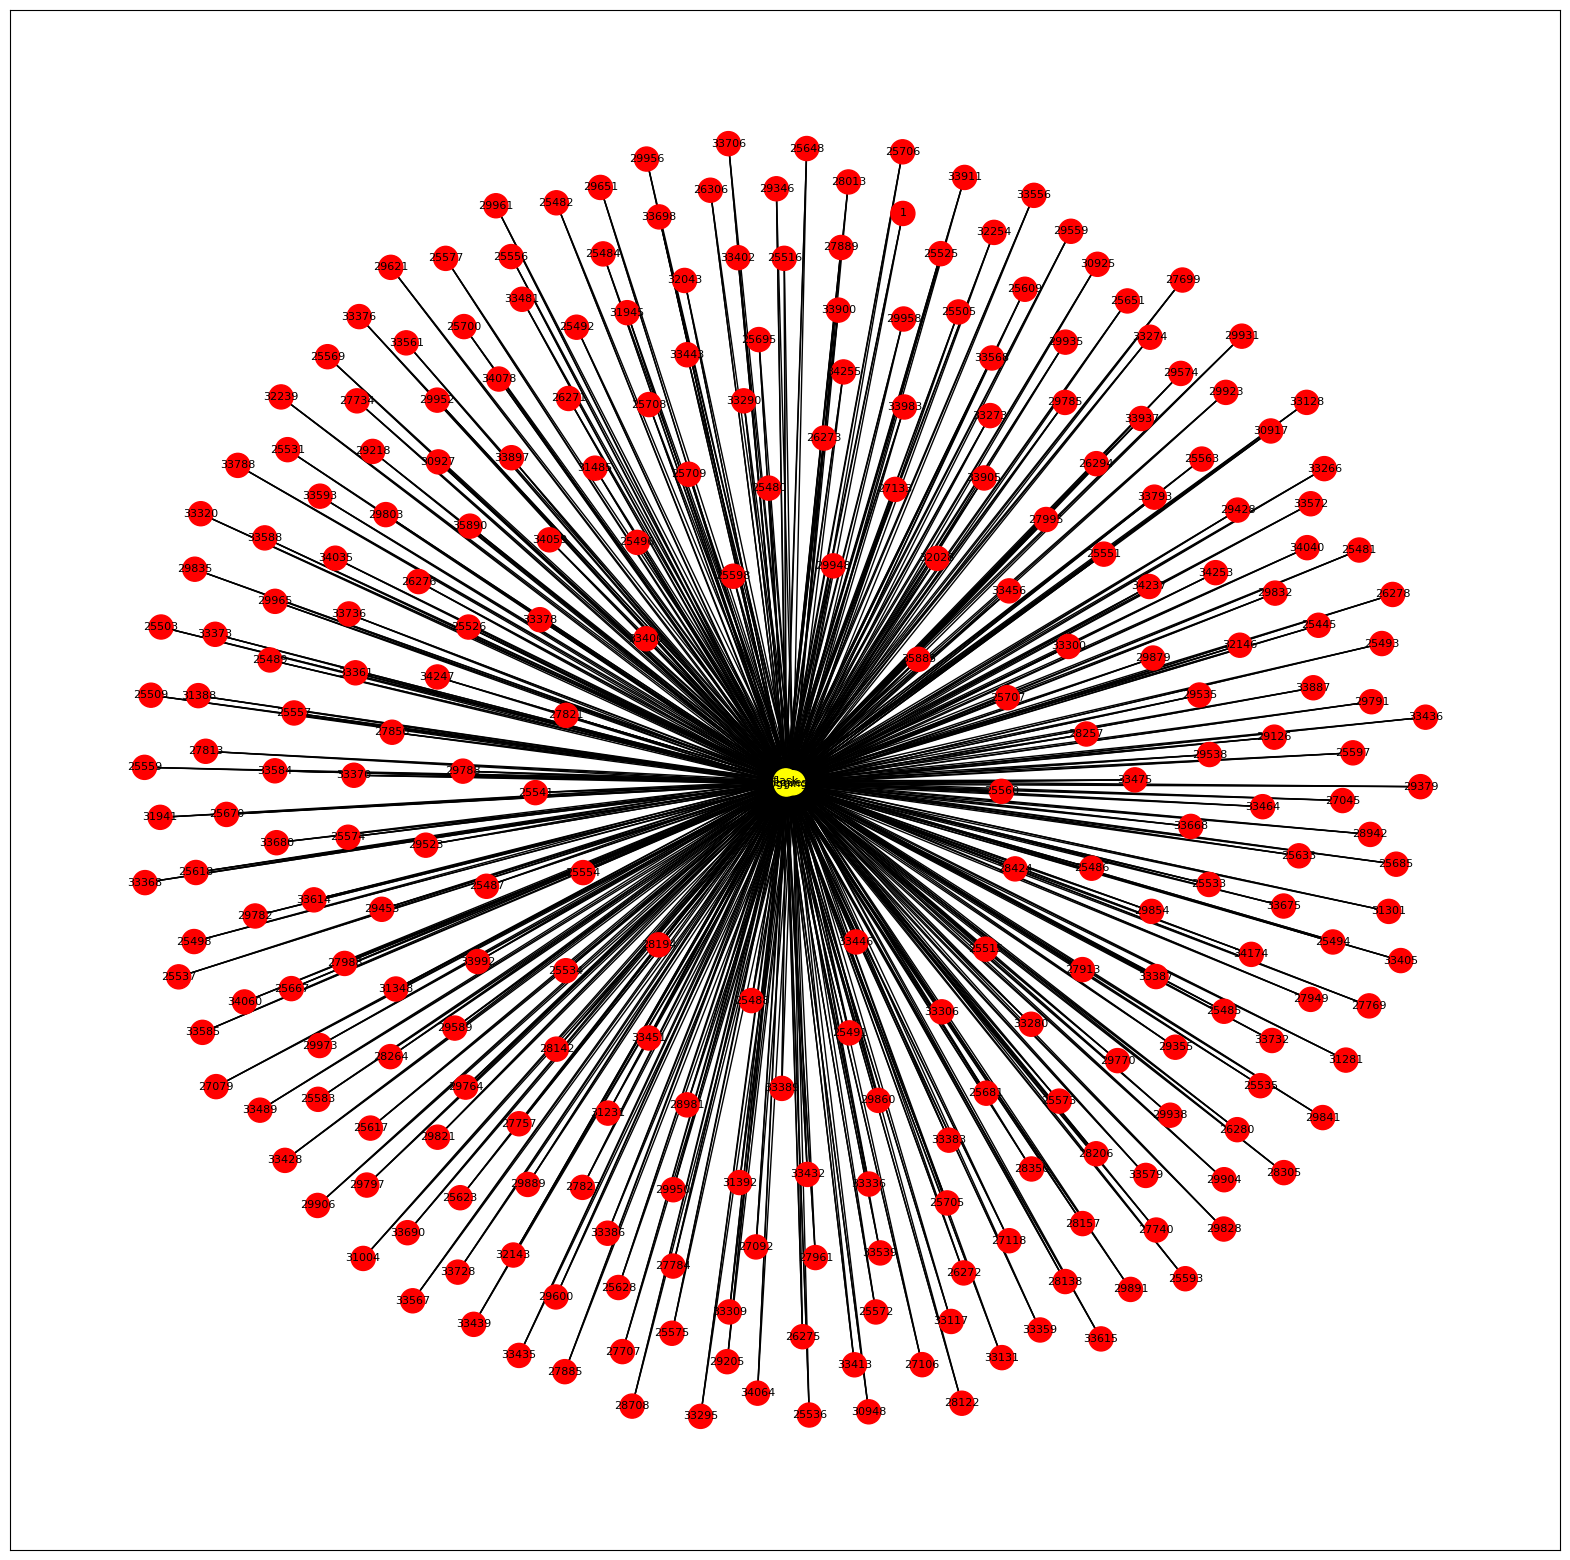

In [13]:
deps_df = pd.DataFrame()


deps_query = salc.sql.text(f"""
            SET SCHEMA 'augur_data';
            SELECT
            	repo_id,
            	dep_name,
            	number 
            FROM
            	(
            	SELECT
            		augur_data.repo_dependencies.dep_name,
            		augur_data.repo_dependencies.repo_id,
            		COUNT ( * ) AS number 
            	FROM
            		augur_data.repo_dependencies 
            	GROUP BY
            		augur_data.repo_dependencies.dep_name,
            		augur_data.repo_dependencies.repo_id 
            	ORDER BY
            		number DESC 
            	) A 
            WHERE
            	dep_name IN ( 'flask', 'requests', 'logging' ) 
            ORDER BY
            	repo_id;
    """)
deps_df = pd.read_sql(deps_query, con=engine)

df_deps = deps_df.groupby(['repo_id', 'dep_name']).size().unstack(fill_value=0)


display(deps_df)
display(df_deps)
deps_df.dtypes
df_deps.dtypes

df_deps = df_deps.reset_index()

df_melted_deps = df_deps.melt(
    ['repo_id'],
     var_name='dep_name', value_name='number') 

print(df_melted_deps)

G = nx.from_pandas_edgelist(df_melted_deps, 
                            source='dep_name',
                            target='repo_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

nodes = G.nodes()


Repo_id = df_melted_deps['repo_id'].to_list()
dep_name = df_melted_deps['dep_name'].to_list()
colors = ['red' if n in Repo_id else 'yellow' for n in nodes]

fig, ax = plt.subplots(figsize=(20,20))
#yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
#blue_patch = mpatches.Patch(color='blue', label='Repository')
#ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

In [14]:
df_melted_commit = df_commit.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [15]:
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit.head()

repo_id                              cntrb_id  number
80      25611  01000000-0200-0000-0000-000000000000     161
573     28438  01000000-0200-0000-0000-000000000000       9
2030    25668  01000000-0400-0000-0000-000000000000       1
2895    29985  01000000-0400-0000-0000-000000000000    2384
2896    29987  01000000-0400-0000-0000-000000000000     169

In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

In [16]:
G = nx.from_pandas_edgelist(df_melted_commit, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [17]:
nodes = G.nodes()

In [18]:
Repo_id = df_melted_commit['repo_id'].to_list()
contributor_id = df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

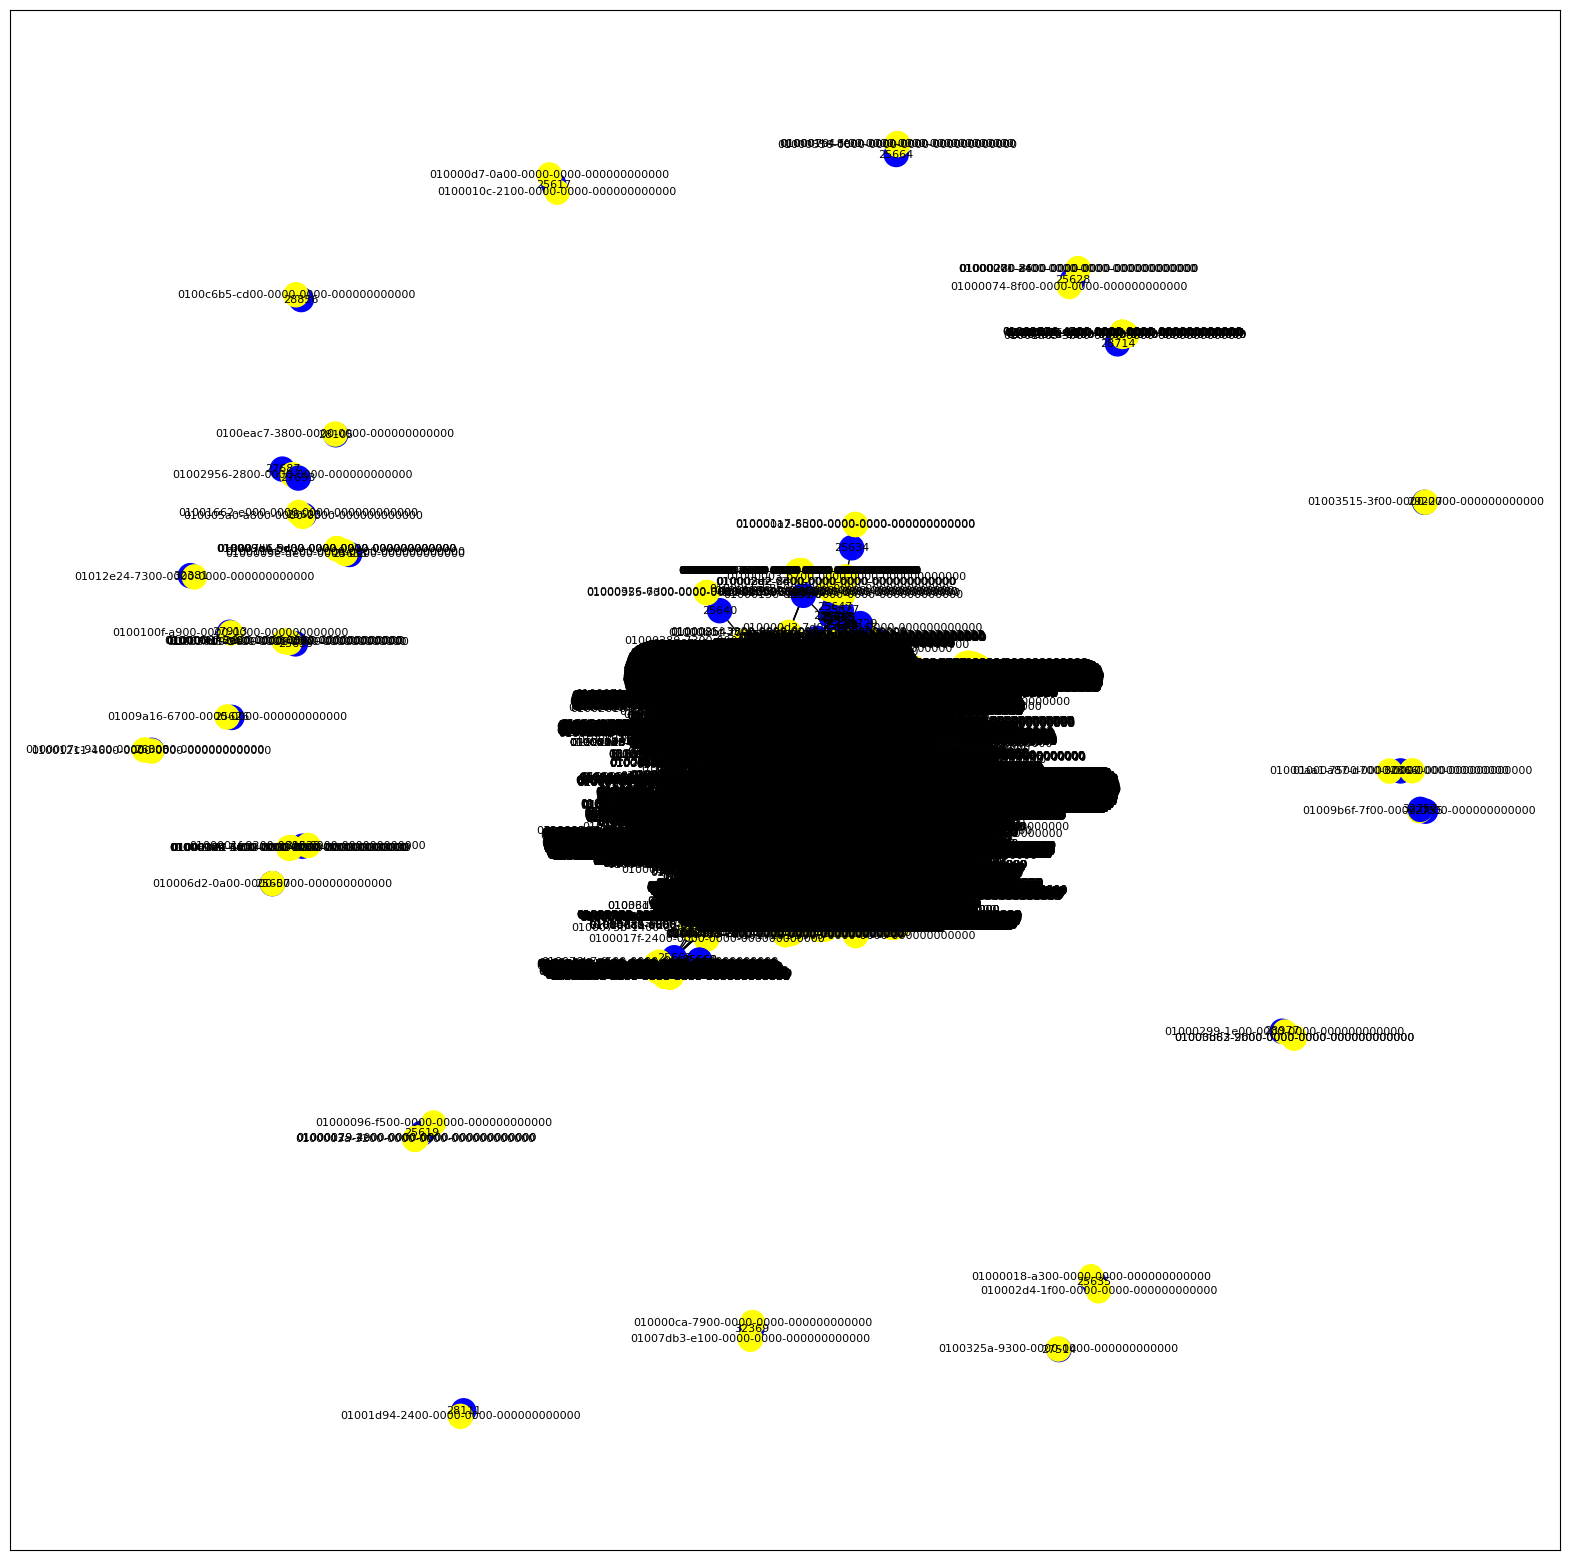

In [19]:
fig, ax = plt.subplots(figsize=(20,20))
#yellow_patch = mpatches.Patch(color='yellow', label='Contributor')
#blue_patch = mpatches.Patch(color='blue', label='Repository')
#ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

What we see above is a certain set of repositories and thier contributors plotted on the same graph. The blue dots represent project repositories and the yellow dots represent their contributors. This gives us an idea of central projects which have a large number of contributors and how other projects are connected to them. However, just given the number of repositories, this graph is hard to dig into, so lets subset this graph to create a smaller plot.

In [20]:
#subsetting the first 50 repo nodes for a smaller plot
smaller_df_melted_commit = df_melted_commit[0:50]

Here, we narrow down the entire set of nodes into view only 50 nodes plotted on a graph. Note, this is just for visual simplicilty. This is not a logical filtering and not all contributors for a project are going to be seen on the same plot

In [21]:
G = nx.from_pandas_edgelist(smaller_df_melted_commit, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [22]:
nodes = G.nodes()

In [23]:
Repo_id = smaller_df_melted_commit['repo_id'].to_list()
contributor_id = smaller_df_melted_commit['cntrb_id'].to_list()
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

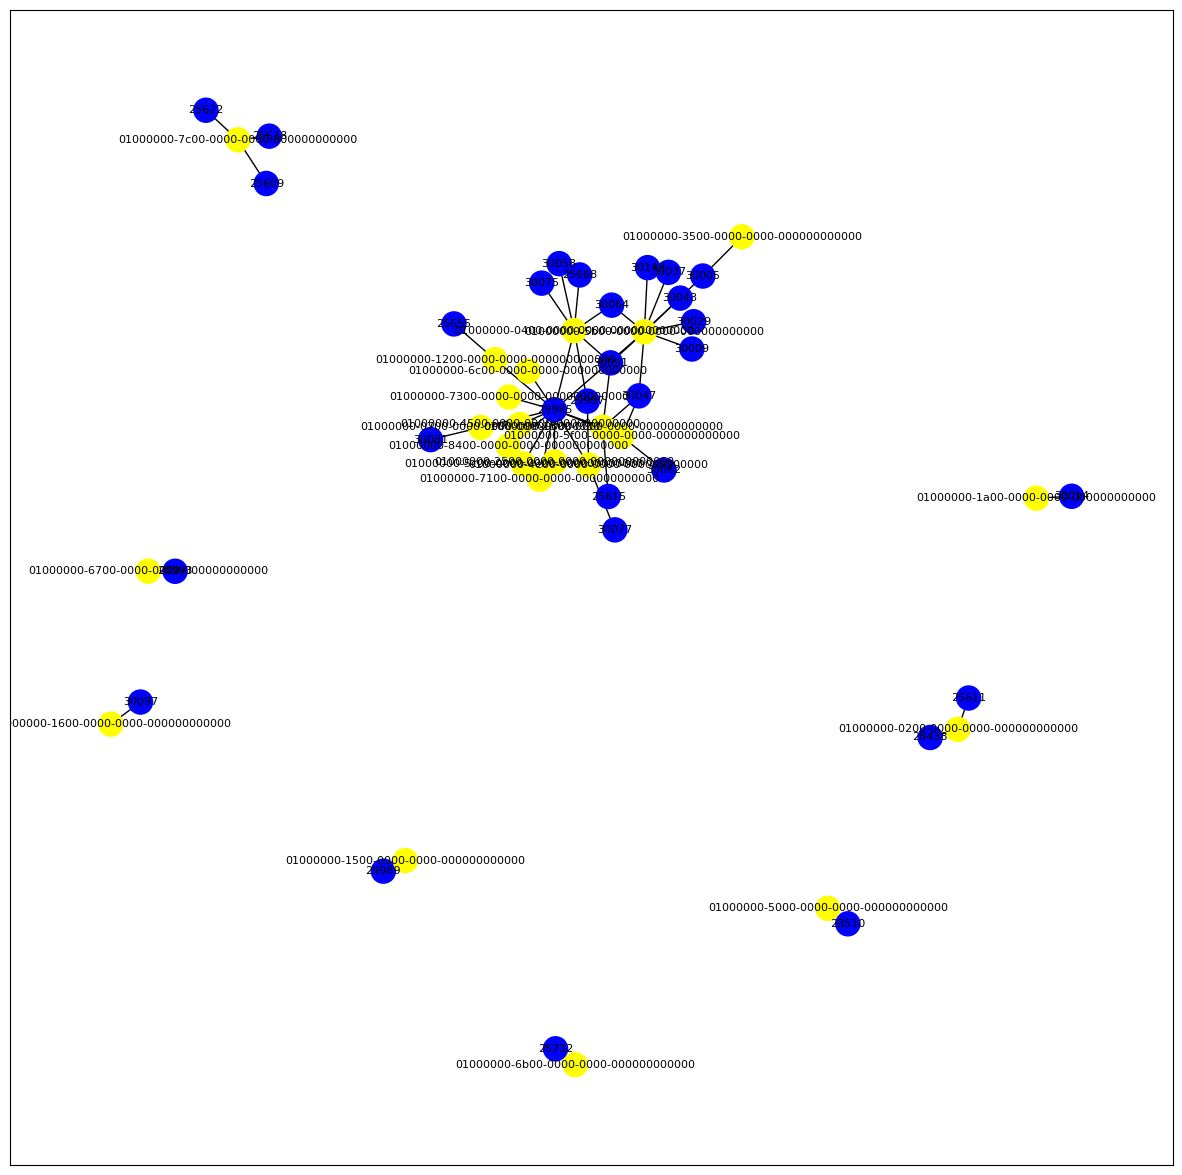

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
#ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### Issue Contributor Graph

We plot the plots similar to above on issue type contribution.

In [25]:
df_issue = issue_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_issue.head()

cntrb_id  01000000-0400-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1100-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1300-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1500-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-2500-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-3300-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-4500-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-4e00-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-6b00-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-6c00-0000-0000-000000000000  ...  \
repo_id                                         ...   
25531                                        0  ...   
25532                                        0  ...   
25533                                        0  ...   
25534                                        0  ...   
25535                                        0  ...   

cntrb_id  01080c8e-3200-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  010810e2-6d00-0000-0000-000000000000  \
repo_id                                          
2553

In [26]:
df_issue = df_issue.reset_index()

In [27]:
df_issue.head()

cntrb_id  repo_id  01000000-0400-0000-0000-000000000000  \
0           25531                                     0   
1           25532                                     0   
2           25533                                     0   
3           25534                                     0   
4           25535                                     0   

cntrb_id  01000000-1100-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1300-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-1500-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-2500-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-3300-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-4500-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-4e00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01000000-6b00-0000-0000-000000000000  ...  \
0                                            0  ...   
1                                            0  ...   
2                                            0  ...   
3                                            0  ...   
4                                            0  ...   

cntrb_id  01080c8e-3200-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  010810e2-6d00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  010812a6-ff00-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cntrb_id  01081742-e100-0000-0000-000000000000  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

cnt

In [28]:
df_melted_issue = df_issue.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [29]:
df_melted_issue = df_melted_issue[df_melted_issue[df_melted_issue.columns[2]] != 0]
df_melted_issue.head()

repo_id                              cntrb_id  number
574     29985  01000000-0400-0000-0000-000000000000       1
575     29987  01000000-0400-0000-0000-000000000000       5
1221    25554  01000000-1100-0000-0000-000000000000       1
2970    29985  01000000-1300-0000-0000-000000000000       4
4168    29985  01000000-1500-0000-0000-000000000000       1

In [30]:
Repo_id = df_melted_issue['repo_id'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [31]:
G = nx.from_pandas_edgelist(df_melted_issue, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [32]:
nodes = G.nodes()

In [33]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

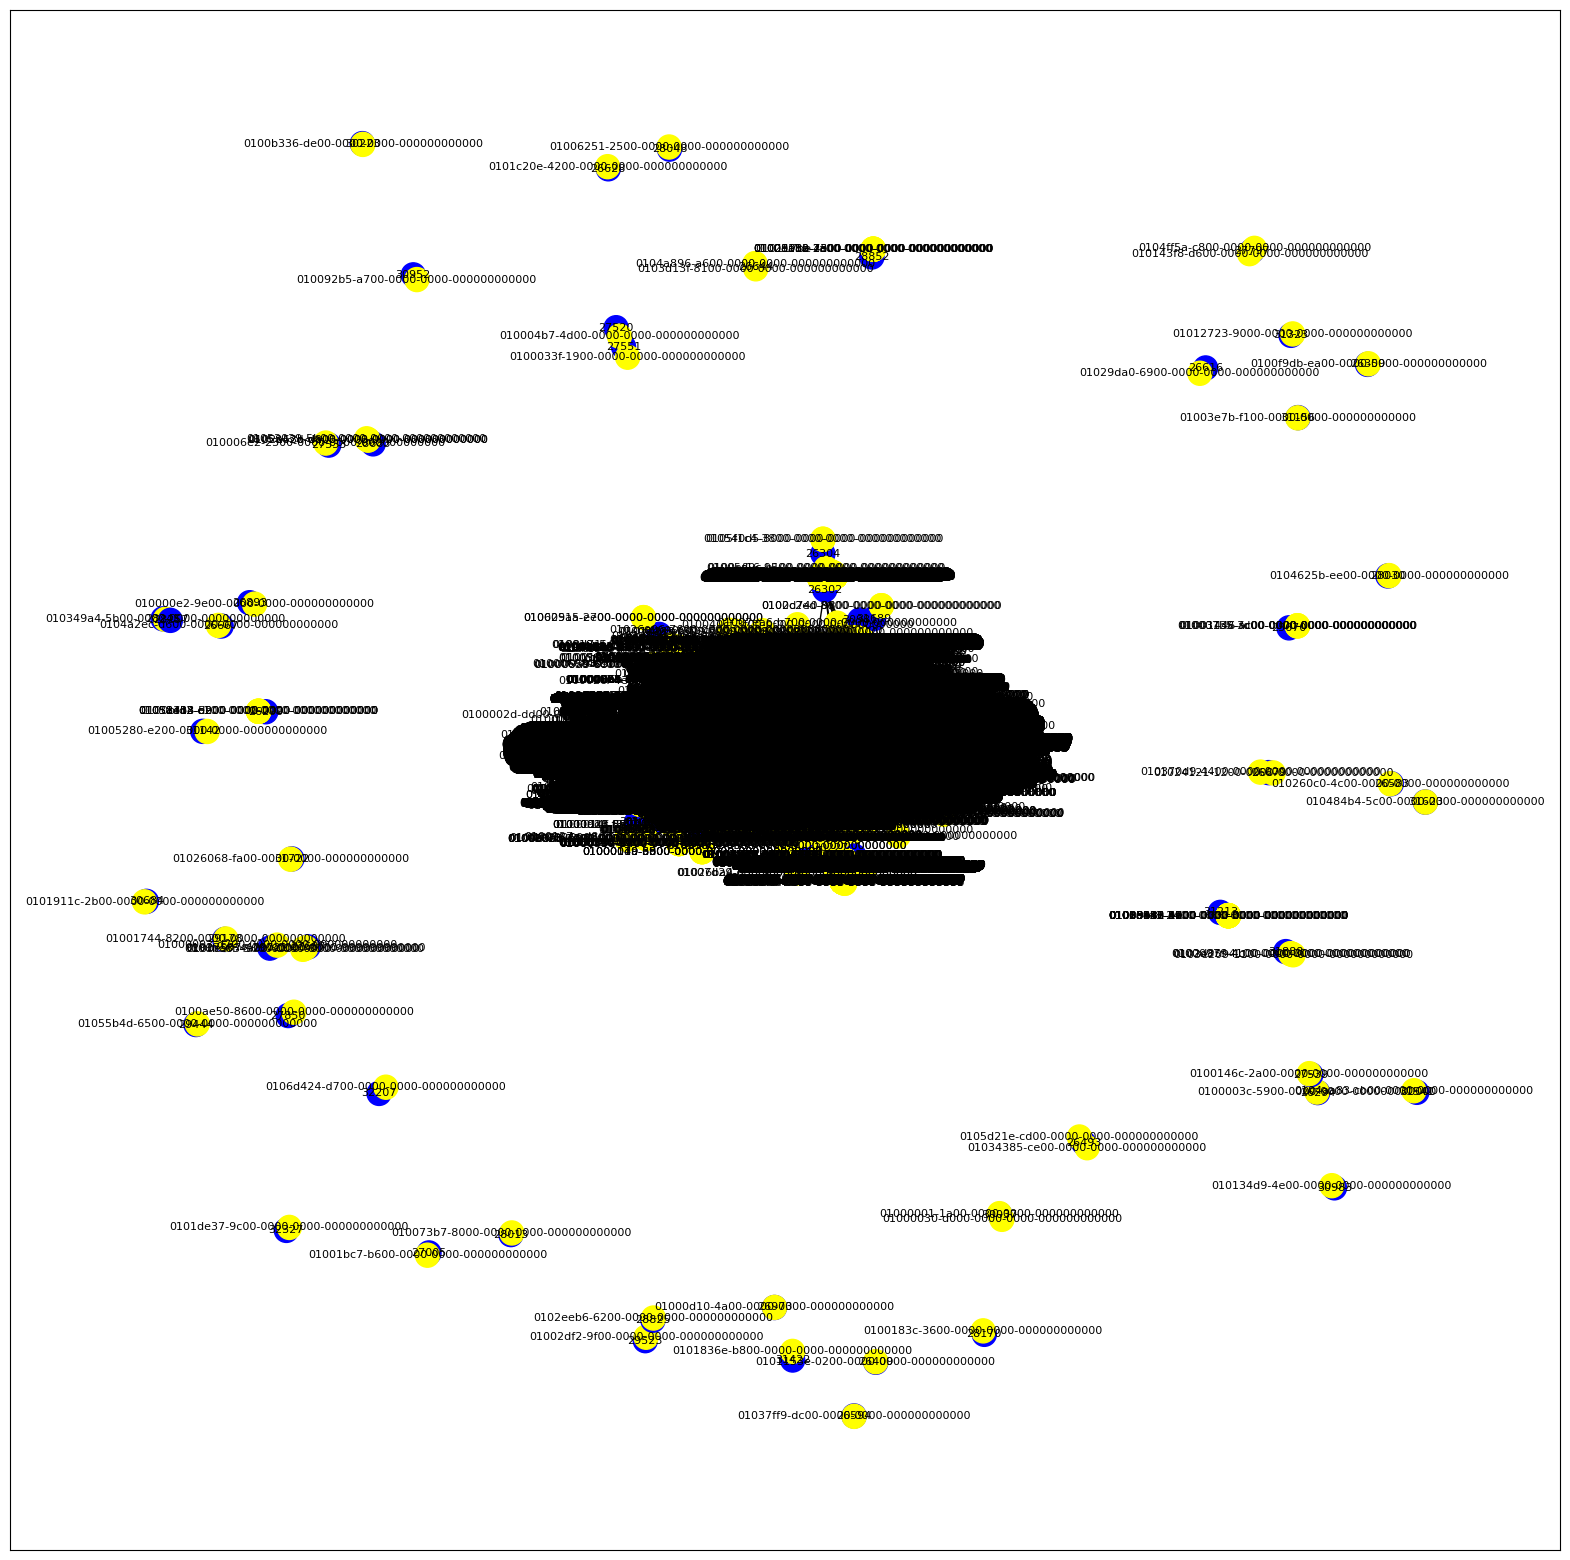

In [34]:
fig, ax = plt.subplots(figsize=(20,20))
#ax.legend(handles=[yellow_patch, blue_patch])
nx.draw_networkx(G, node_color=colors, font_size=8, ax=ax)

### PR Contributor Graph

We now plot similar graphs as above for Pull Request type contributors

In [35]:
df_pr = pr_contrib.groupby(['repo_id', 'cntrb_id']).size().unstack(fill_value=0)
df_pr.head()

cntrb_id  01000000-0700-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-1600-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-3300-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-4500-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-4d00-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-5b00-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-6600-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-6700-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-6c00-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  01000000-8000-0000-0000-000000000000  ...  \
repo_id                                         ...   
25531                                        0  ...   
25532                                        0  ...   
25533                                        0  ...   
25534                                        0  ...   
25535                                        0  ...   

cntrb_id  010793ad-e700-0000-0000-000000000000  \
repo_id                                          
25531                                        0   
25532                                        0   
25533                                        0   
25534                                        0   
25535                                        0   

cntrb_id  010797d1-e700-0000-0000-000000000000  \
repo_id                                          
2553

In [36]:
df_pr = df_pr.reset_index()

In [37]:
df_melted_pr = df_pr.melt(
    ['repo_id'],
    var_name = 'cntrb_id',value_name='number')

In [38]:
df_melted_pr = df_melted_pr[df_melted_pr[df_melted_pr.columns[2]] != 0]
df_melted_pr.head()

repo_id                              cntrb_id  number
618     29985  01000000-0700-0000-0000-000000000000       1
646     30081  01000000-0700-0000-0000-000000000000       1
1915    29985  01000000-1600-0000-0000-000000000000       1
1951    30097  01000000-1600-0000-0000-000000000000       1
3245    30091  01000000-3300-0000-0000-000000000000       1

In [39]:
Repo_id = df_melted_issue['repo_id'].to_list()
contributor_id = df_melted_issue['cntrb_id'].to_list()

In [40]:
G = nx.from_pandas_edgelist(df_melted_pr, 
                            source='repo_id',
                            target='cntrb_id',
                            edge_attr='number',
                            create_using=nx.MultiGraph())

In [41]:
nodes = G.nodes()

In [42]:
colors = ['blue' if n in Repo_id else 'yellow' for n in nodes]

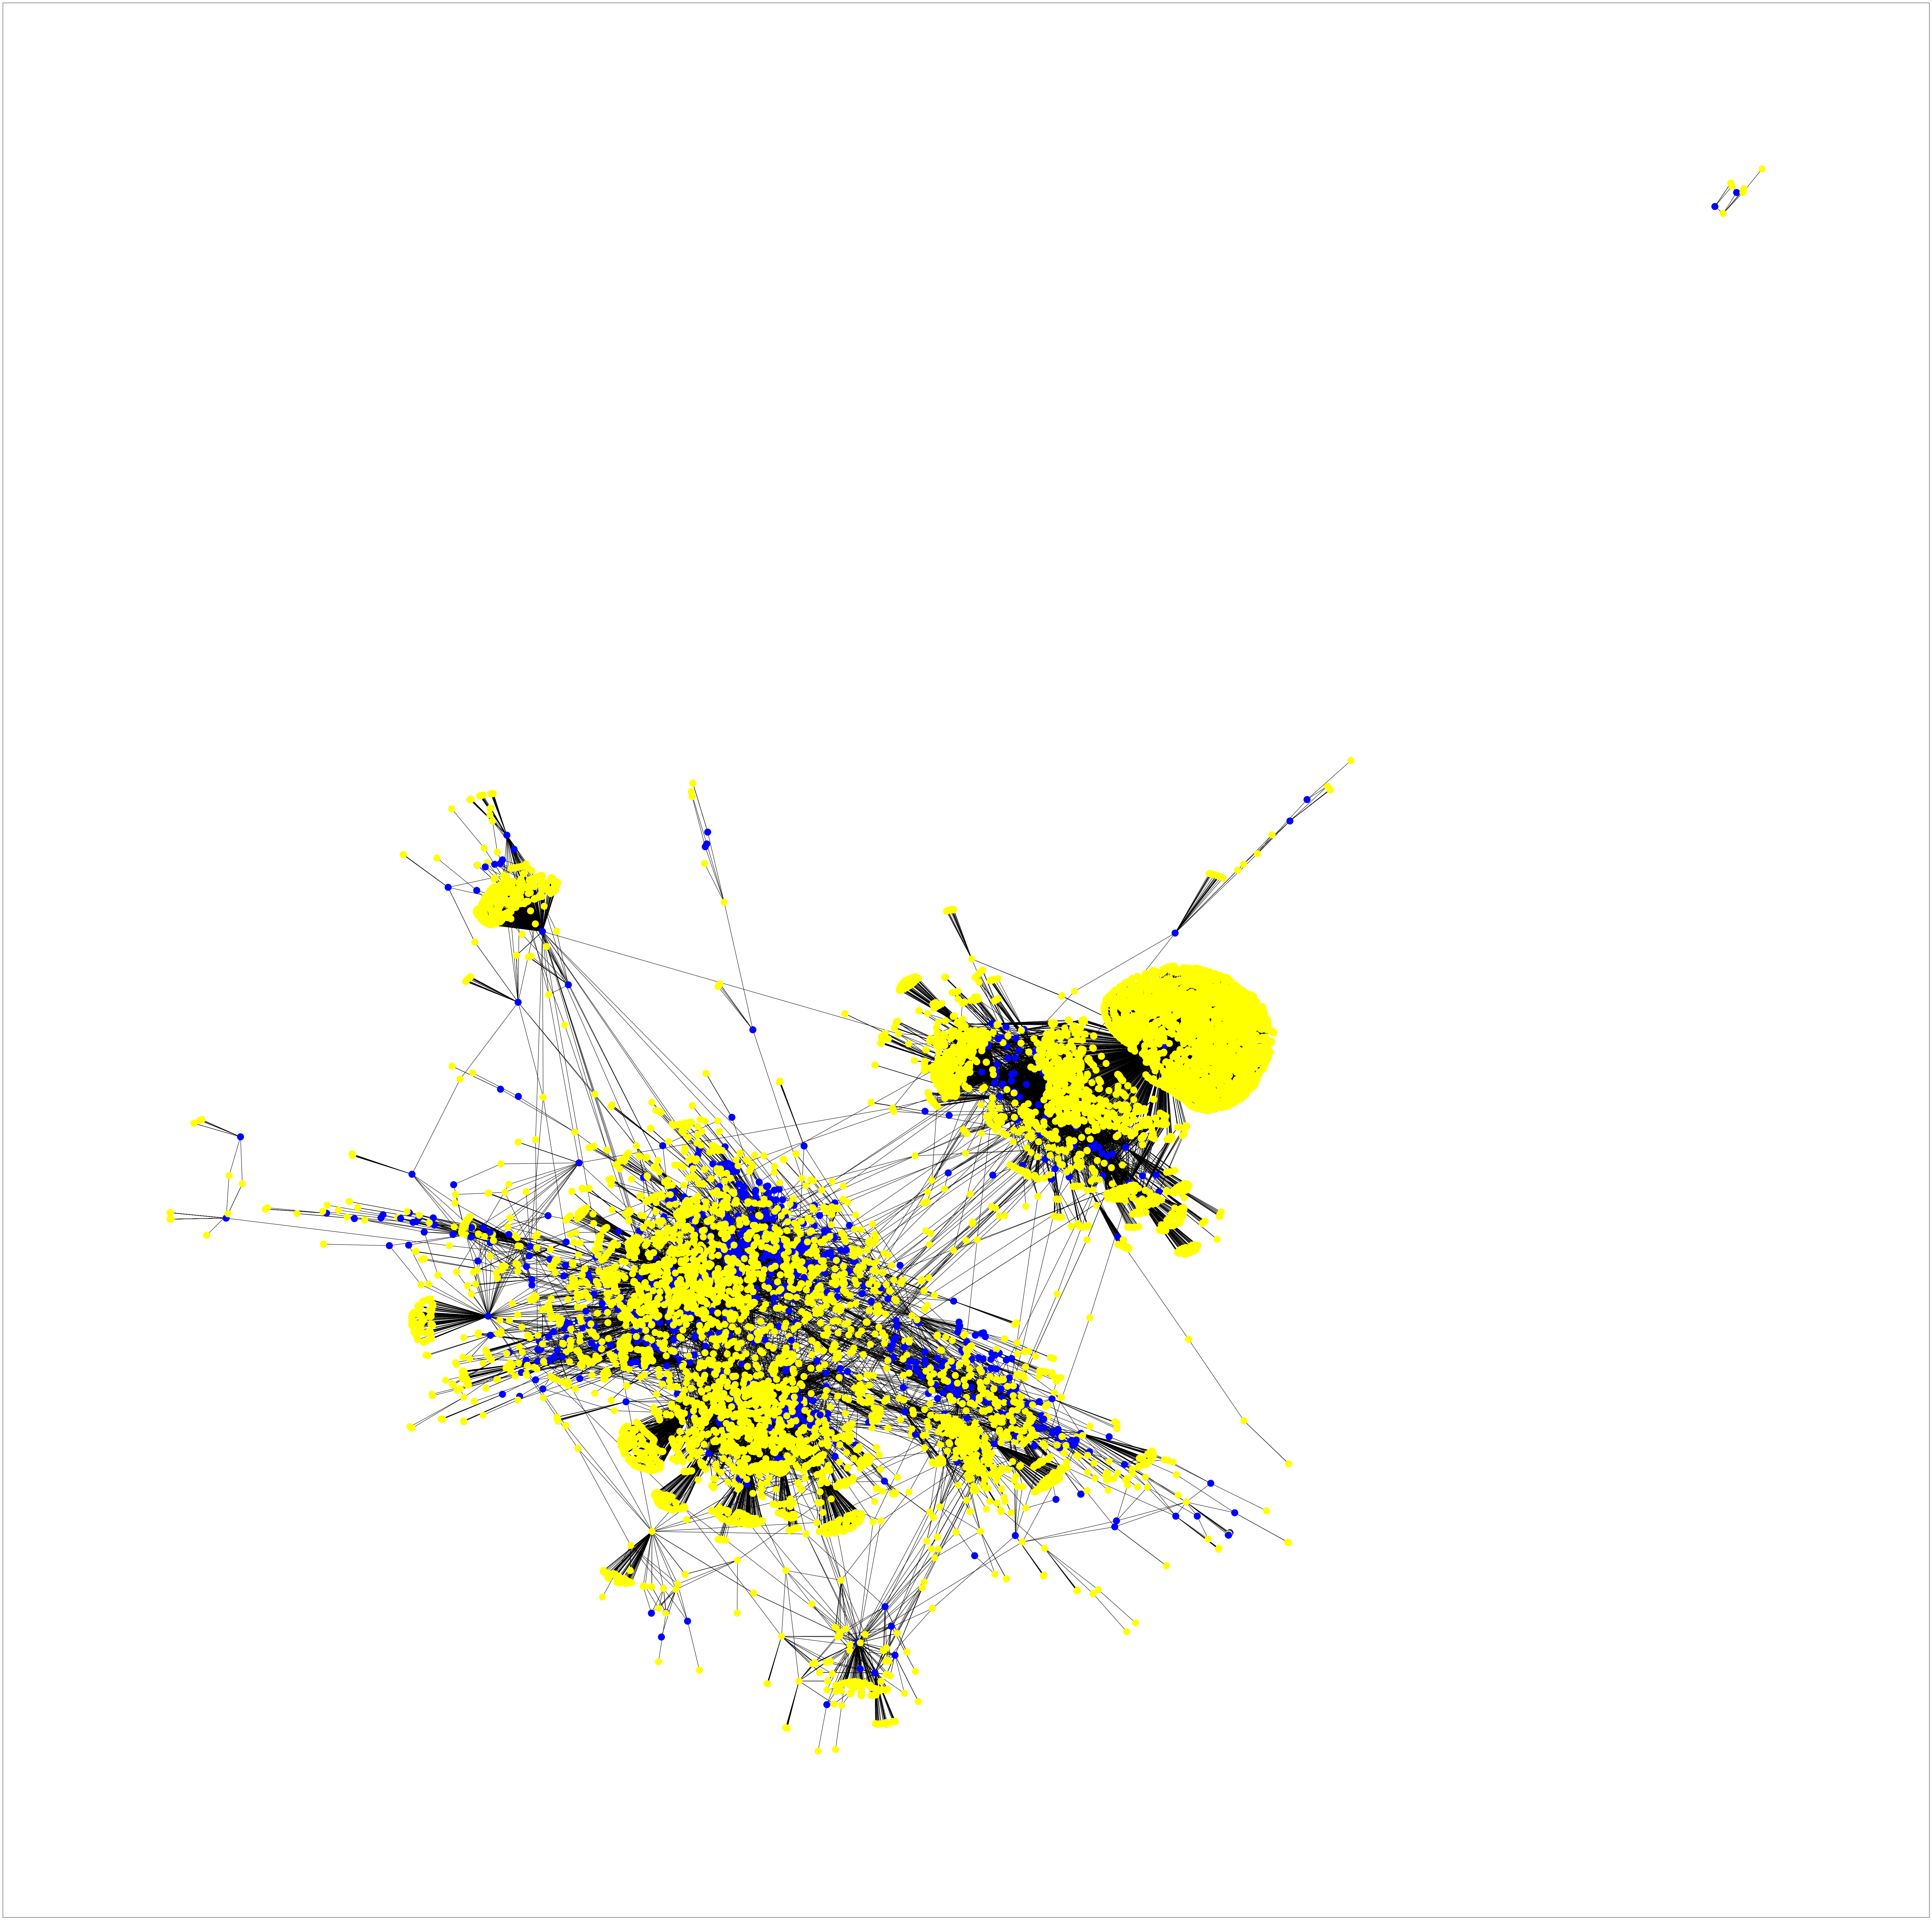

In [54]:
fig, ax = plt.subplots(figsize=(90,90))
pos = nx.fruchterman_reingold_layout(G)
nx.draw_networkx(G, node_color=colors, with_labels=False, font_size=8, ax=ax)

## Nodes as projects edges as contributors

In this section, we represent data in a different way and try out another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

Lets pick the **Pull Request** type contribution for these graph plots as an example

In [44]:
df_melted_pr.head()

repo_id                              cntrb_id  number
618     29985  01000000-0700-0000-0000-000000000000       1
646     30081  01000000-0700-0000-0000-000000000000       1
1915    29985  01000000-1600-0000-0000-000000000000       1
1951    30097  01000000-1600-0000-0000-000000000000       1
3245    30091  01000000-3300-0000-0000-000000000000       1

In [45]:
contributorGraph = {}
for i, row in df_melted_pr.iterrows():
    if row['cntrb_id'] not in contributorGraph:
        contributorGraph[row['cntrb_id']] = []
    if(row['number'] > 0):
        contributorGraph[row['cntrb_id']].append((row['repo_id'], row['number']))

In [46]:
list(contributorGraph.items())[:10]

[(UUID('01000000-0700-0000-0000-000000000000'), [(29985, 1), (30081, 1)]),
 (UUID('01000000-1600-0000-0000-000000000000'), [(29985, 1), (30097, 1)]),
 (UUID('01000000-3300-0000-0000-000000000000'), [(30091, 1)]),
 (UUID('01000000-4500-0000-0000-000000000000'), [(29985, 2)]),
 (UUID('01000000-4d00-0000-0000-000000000000'), [(29987, 1)]),
 (UUID('01000000-5b00-0000-0000-000000000000'), [(29985, 6)]),
 (UUID('01000000-6600-0000-0000-000000000000'), [(30070, 1)]),
 (UUID('01000000-6700-0000-0000-000000000000'), [(29987, 1)]),
 (UUID('01000000-6c00-0000-0000-000000000000'), [(29985, 2), (30188, 1)]),
 (UUID('01000000-8000-0000-0000-000000000000'), [(29985, 3)])]

`contributorGraph` above is a dictionary where each key is a project repository, and the value is a list of **"connected"** project repositories and the number of **"shared connections"** between them. Lets explain **"connected"** repositories and shared "connections".

structure of `contributorGraph` =  
{  
`repo1`: [(`repo2`, `PRs by same authors in repo 1 and repo 2`)],  
 `repo2`: [(`repo4`, `PRs created by same authors in repo 1 and repo 4` ), (`repo5`, `PRs by same authors in repo 2 and repo 5`)]  
}

**"shared connections"** constitute of *commits*, *pull requests*, *issues* and *pull request reviews* that are made by the same contributor.
We will call 2 project repositories **"connected"** if they have a **"shared connection"** between them. 
This means if they have a contributor who makes a *commit*, *pull request*, *issue* or *pull request review* in both the repositories, they count as a shared contributor and the repositories are connected. 

We track the number of shared contributions between 2 repositories for creating this graph plot.

In [47]:
commonRepoContributionsByContributor = collections.defaultdict(int)
for key in contributorGraph:
    if len(contributorGraph[key])-1 <= 0:
        continue
    for repoContributionIndex in range(len(contributorGraph[key])-1):
        commonRepoContributionsByContributor[(contributorGraph[key][repoContributionIndex][0], contributorGraph[key][repoContributionIndex+1][0])] += contributorGraph[key][repoContributionIndex][1]+contributorGraph[key][repoContributionIndex+1][1]
print(commonRepoContributionsByContributor)

defaultdict(<class 'int'>, {(29985, 30081): 126, (29985, 30097): 28, (29985, 30188): 202, (29985, 30039): 4091, (30039, 30166): 8, (29985, 30150): 35, (30150, 30152): 646, (29985, 30214): 3, (29985, 30116): 240, (29985, 30070): 22, (30070, 30101): 2, (29985, 30047): 2490, (30047, 30083): 29, (29985, 30134): 4, (29985, 30072): 952, (30072, 30091): 12, (30091, 30116): 10, (30116, 30140): 4, (30140, 30146): 2, (30146, 30152): 2, (30152, 30171): 12, (30171, 30182): 8, (29985, 29987): 29877, (29987, 30072): 22, (30072, 30079): 8, (30079, 30083): 25, (30083, 30103): 20, (30103, 30116): 19, (30116, 30126): 12, (30126, 30142): 2, (30142, 30147): 6, (30147, 30149): 2, (30149, 30152): 11, (30152, 30153): 594, (30153, 30162): 14, (30162, 30166): 97, (30166, 30169): 1710, (30169, 30207): 3, (29985, 30058): 210, (30058, 30083): 8, (30083, 30105): 2, (30105, 30166): 9, (29985, 30075): 216, (29987, 30047): 61, (30083, 30186): 3, (30070, 30152): 2, (30047, 30128): 8, (29985, 30166): 1252, (30047, 3015

`commonRepoContributionsByContributor` is a nested dictionary consisting of dictionaries of repository pairs and their common contributions. 

structure of `commonRepoContributionsByContributor` =  
{  
(`repo1, repo2`): `PRs by same authors in repo 1 and repo 2`,  
(`repo2, repo4`): `PRs by same authors in repo 2 and repo 4`,  
(`repo2, repo5`): `PRs by same authors in repo 2 and repo 5`,   
}

In [48]:
res = []
for key in commonRepoContributionsByContributor:
    res.append(tuple(str(k) for k in list(key)) + (commonRepoContributionsByContributor[key],))

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [49]:
g = nx.Graph()
g.add_weighted_edges_from(res)

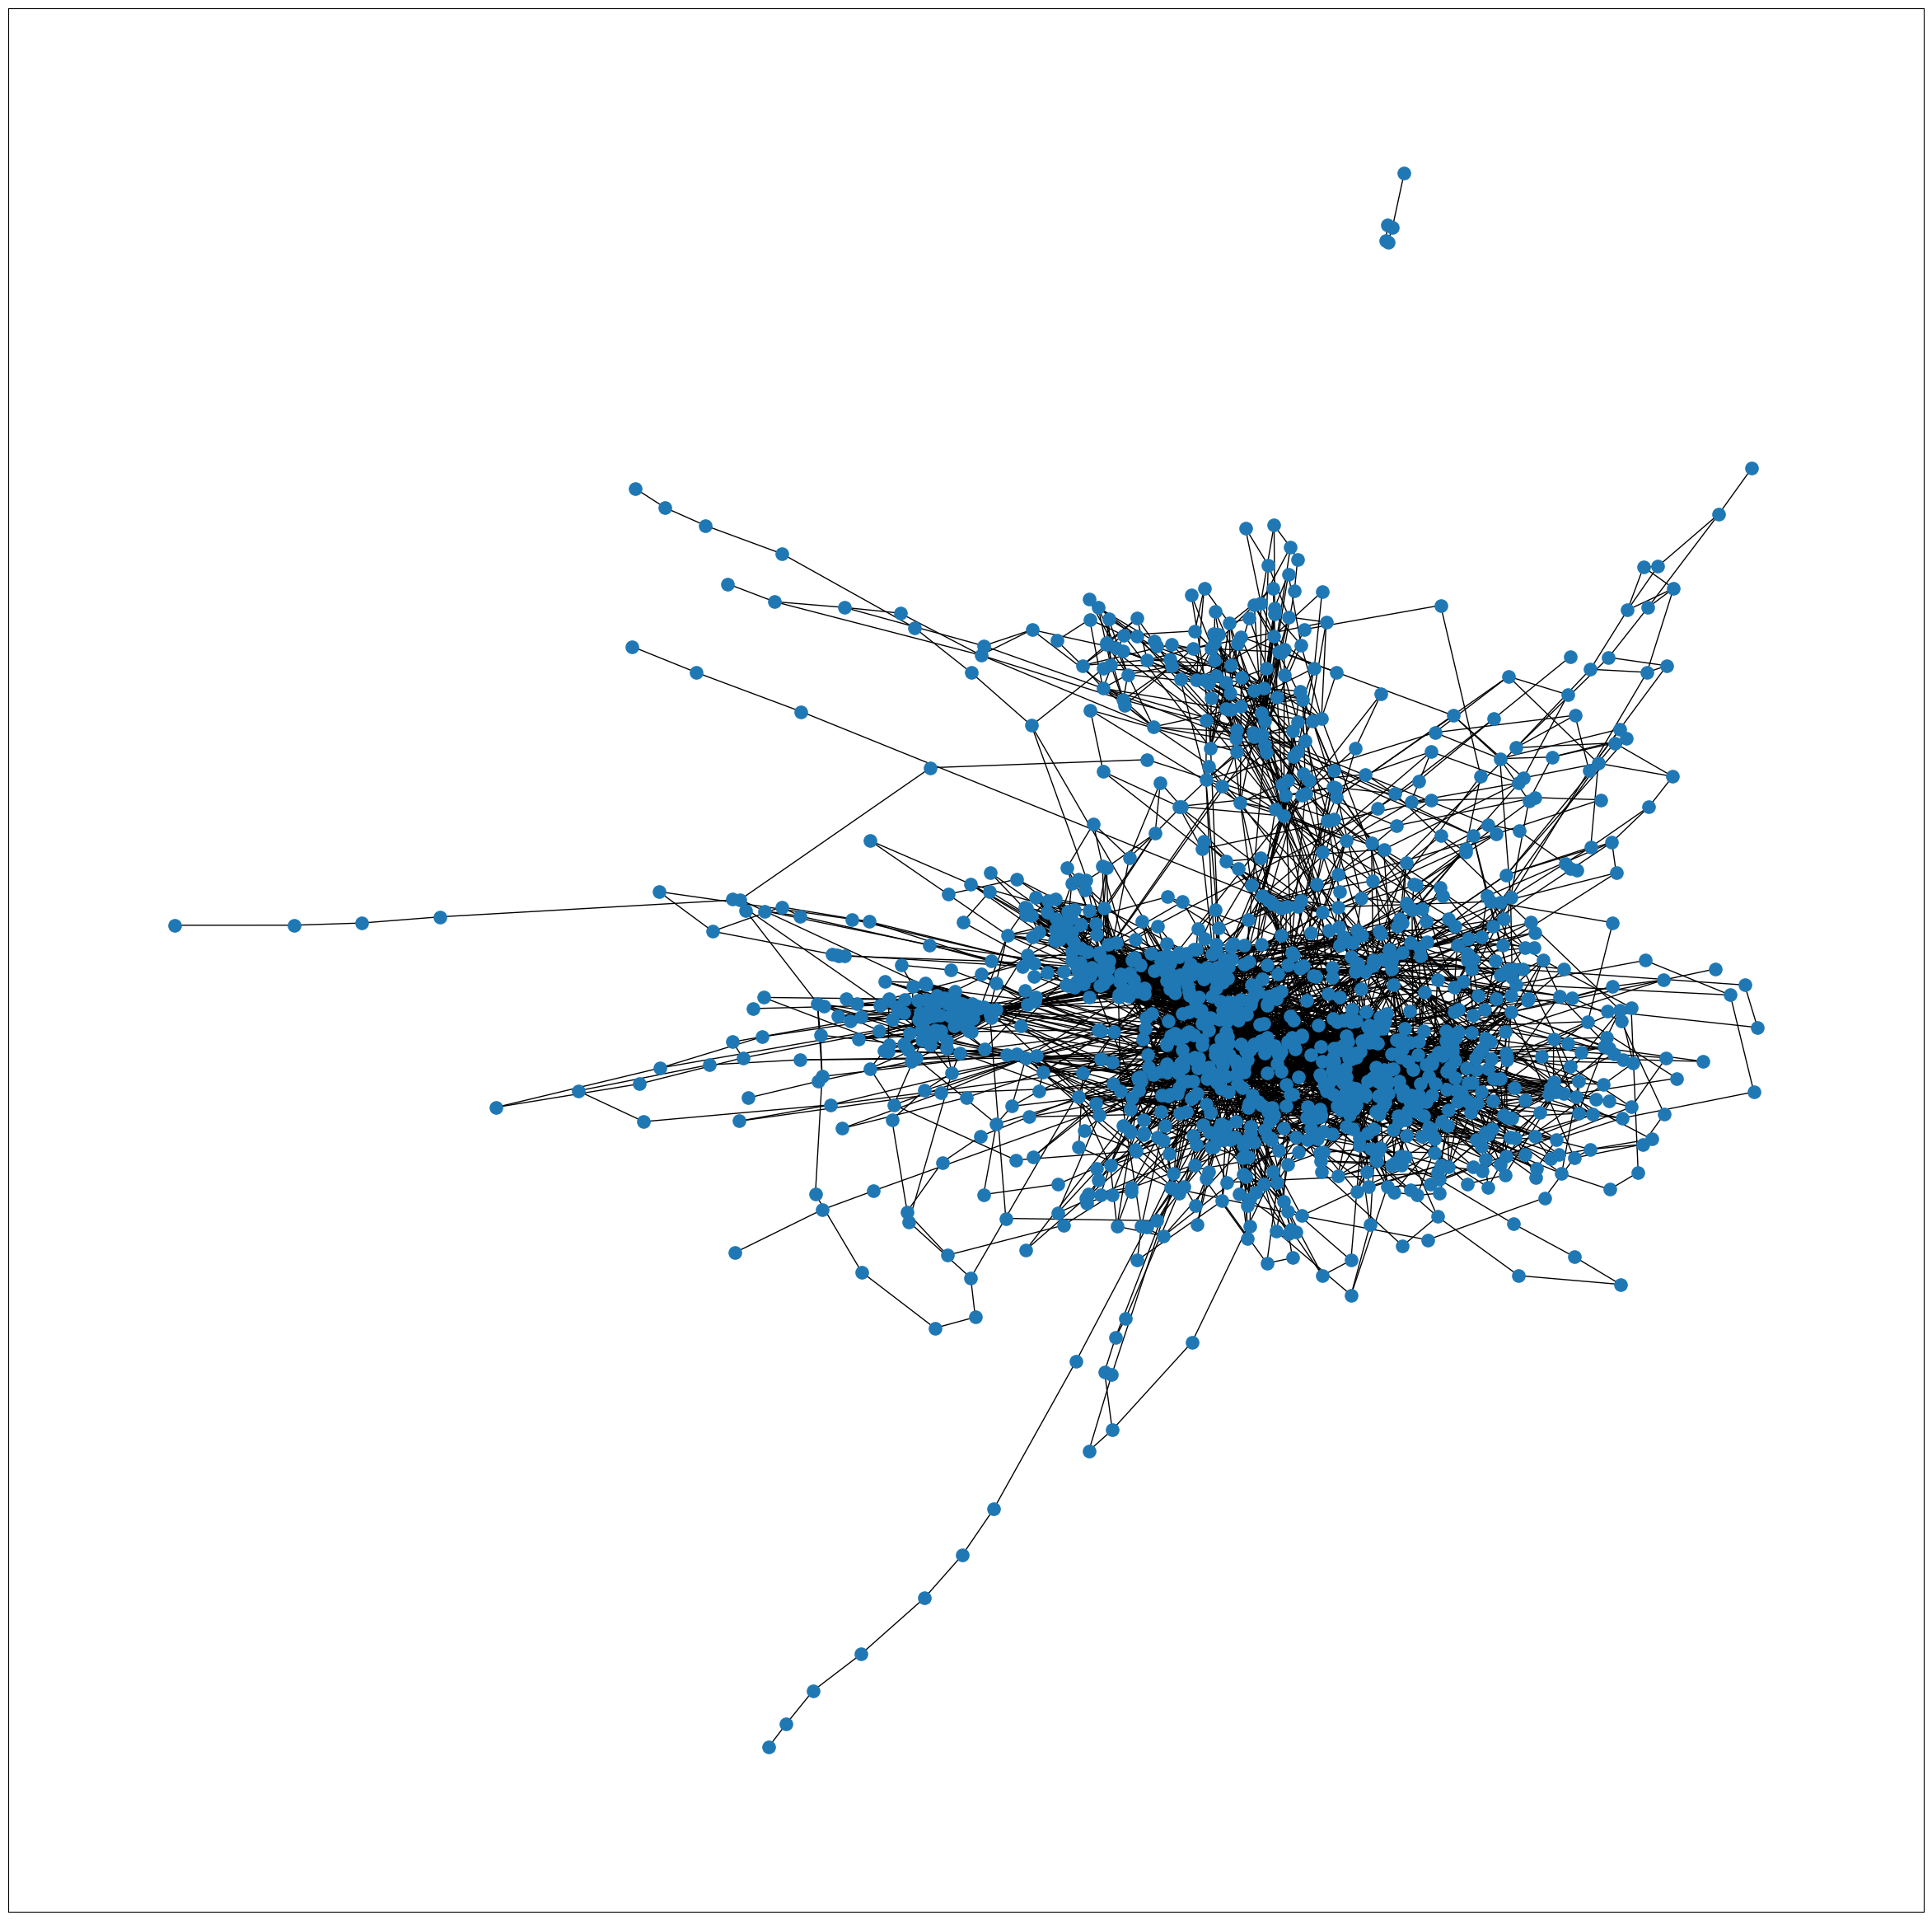

In [51]:
fig, ax = plt.subplots(figsize=(30,30))
pos = nx.fruchterman_reingold_layout(g)
nx.draw_networkx(g, node_size=120, with_labels=False, font_size=14, ax=ax)


The above graph represents project repositories and how close or far they are to each other based on their degree of connected (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We are not plotting lone projects in this graph as we want to identify project repositories in connection to existing known repositories.  
Note: this is not a complete (fully-connected) graph. All projects are not **"connected"** to each project. See above for the definition of **"connected"** 

## Conclusion

In this notebook, we created initial graph representations of existing open source GitHub repositories falling under a certain category using [NetworkX](https://networkx.org/). 

We used 2 type of graph representations:

- One where repositories and contributors both are both nodes (differently colored). Viewing which repositories share which set of contributors and analyzing their clusters can give an idea about how projects are connected to each other and to what degree 
- One where repositories are nodes, and edges are number of contributions. The distance between repositories, how close or far they are will depend on the number of shared contributions that exist between them.